In [2]:
using HDF5, ImageView, ReadVTK, LightXML, PyPlot
include("/media/shared/Marc/Gits/multi_quickPIV/src/multi_quickPIV.jl")

Xlib: sequence lost (0x100ac > 0xae) in reply type 0x0!
Xlib: sequence lost (0x100b1 > 0xb3) in reply type 0x0!
Xlib: sequence lost (0x100b6 > 0xb8) in reply type 0x0!


Main.multi_quickPIV

## Loading Data

In [4]:
# LOADING SLICES FROM RUTIAN'S SINGLE LAYER H5 FILES

path   = "/media/shared/Rutian/Headon_layer_data/Headon_single_layer/video_3/"
fid    = h5open( path*"headon_layer_1.h5", "r" ); 
slices = read( fid["data"] ); 
close( fid );

In [3]:
# LOADING SLICES FROM THE 3D VTI VOLUMES

function get_vti_size( filename )
    vtk_file       = VTKFile( filename )
    vtk_cell_data  = get_cell_data(vtk_file)
    vtk_data_array = vtk_cell_data["intensities"]
    data_size, _   = ReadVTK.get_wholeextent(vtk_data_array.vtk_file.xml_file, false)
    return Tuple( data_size .- 1 )
end

function read_vti_vol!( filename, out::Array{T,N} ) where {T,N}
    vtk_file       = VTKFile( filename )
    vtk_cell_data  = get_cell_data(vtk_file)
    vtk_data_array = vtk_cell_data["intensities"]
    data_size, _   = ReadVTK.get_wholeextent(vtk_data_array.vtk_file.xml_file, false)
    out[:] .= T.( get_data( vtk_data_array ) );
    return nothing
end

function get_slices( path, slice_idx=3; tp0=0, tp1=394, typ=UInt16 )
    vol_size = get_vti_size( path*"tp$(tp0).vti" )
    slices   = zeros( typ, vol_size[1:2]..., length(tp0:tp1) ); 
    tmp_vol  = zeros( typ, vol_size ); 
    cont = 1; 
    for t in tp0:tp1
        read_vti_vol!( path * "tp$(t).vti", tmp_vol ); 
        slices[ :, :, cont ] .= tmp_vol[ :, :, slice_idx ];
        cont += 1
    end
    return slices
end

get_slices (generic function with 2 methods)

In [4]:
path = "/media/shared/Headon_data/data/single_channel/video_3/"
@time slices = get_slices( path, 2, typ=UInt16 ); 

 52.786546 seconds (2.13 M allocations: 34.197 GiB, 0.74% gc time, 2.85% compilation time)


In [ ]:
slices = nothing

In [ ]:
ImageView.imshow( slices )

In [1]:
# Read h5 file in which image data is saved. 
using HDF5
function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end

read_h5 (generic function with 1 method)

In [4]:
# Pick the slice
slices = read_h5("v1_headon_layer_2.h5")

1024×1024×24 Array{Float64, 3}:
[:, :, 1] =
 1402.0  1387.0  1347.0  1659.0  1493.0  …    49.0    61.0    31.0    20.0
 3530.0  2014.0  2119.0  4768.0  4352.0       60.0   329.0    38.0    24.0
 1558.0  1422.0  3592.0  2834.0  3460.0       34.0    36.0    82.0   864.0
 3335.0  4434.0  1774.0  2629.0  1081.0      444.0    49.0    29.0    34.0
  994.0  2179.0  3149.0  2196.0  2168.0       48.0    85.0    70.0   316.0
 2709.0  3785.0  3873.0  3324.0  3976.0  …    38.0    77.0   804.0    55.0
 3259.0  2193.0  5743.0  1986.0  2779.0        5.0    45.0    30.0    66.0
 2402.0  3360.0  2578.0  2816.0  5472.0       79.0    88.0    37.0    32.0
 3361.0  1626.0  2418.0  2892.0  5944.0       47.0   251.0   676.0    12.0
 2637.0  2713.0  4914.0  4849.0  3141.0       44.0    28.0    33.0    30.0
 1392.0  2632.0  5179.0  2287.0  2294.0  …    47.0    39.0    37.0    74.0
 1878.0  3972.0  2886.0  3261.0  1436.0       20.0     9.0    49.0    38.0
 1104.0  4348.0  2542.0  4817.0  2076.0       15.0    37

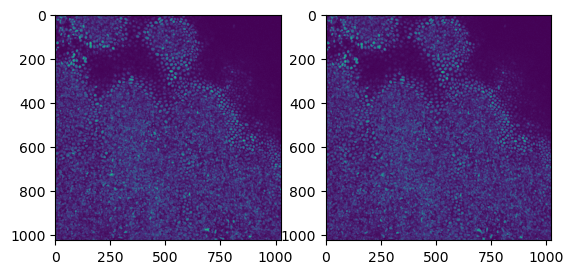

PyObject <matplotlib.image.AxesImage object at 0x0000015AE881E0E0>

In [9]:
using PyPlot

img1 = slices[ :, :, 20]; 
img2 = slices[ :, :, 21]; 

subplot( 1, 2, 1 ); imshow(img1)
subplot(1, 2, 2); imshow(img2)

## Running PIV

In [116]:
#using Pkg
#Pkg.add(path="multi_quickPIV") 
#using multi_quickPIV
#img1 = slices[ :, :, 230 ]; 
#img2 = slices[ :, :, 231 ]; 

pivparams = multi_quickPIV.setPIVParameters( threshold=100, computeSN=true ); 

@time VF, SN = multi_quickPIV.PIV( img1, img2, pivparams)#, precision=32 );  # precision for converting to Float 32 or 64.

  2.800716 seconds (2.58 M allocations: 222.449 MiB, 18.41% gc time, 93.33% compilation time)


([0.0 0.0 … 2.3196580904485025 0.0; 0.0 0.0 … 1.0405743714561098 1.0;;; 0.0 0.05045487959521466 … 0.863566678235296 0.0; 0.0 0.8013242840739707 … 0.6567690523951519 3.0;;; 0.0 0.4820548738744943 … 1.1511409323228374 0.0; 0.0 -0.0053128049259143495 … -0.48105821490723777 0.0;;; … ;;; 9.022111030016937 -10.0 … 0.26857892243069514 0.0; 6.904292182453236 8.0 … 2.9231373402349075 2.0;;; 3.0 -0.7626822178217214 … 2.7811170474659104 0.0; -10.0 -7.082949138229174 … 1.7887996003127906 1.0;;; 1.148101573764258 -6.006532731030189 … 2.0 0.0; -6.708162837400232 -7.934132310634782 … 0.0 0.0], [1.3279415641336185 1.5555086500973305 … 0.9937084341518239 0.9897717476798226; 1.4778059440250775 1.4505332291794981 … 0.9886783590149183 0.9895282462940442; … ; 1.038587351697802 1.2976673684794977 … 1.2423989576173553 1.2858933756107036; 1.2420597057631664 1.093943654707254 … 1.180563529631406 1.1868253792817023])

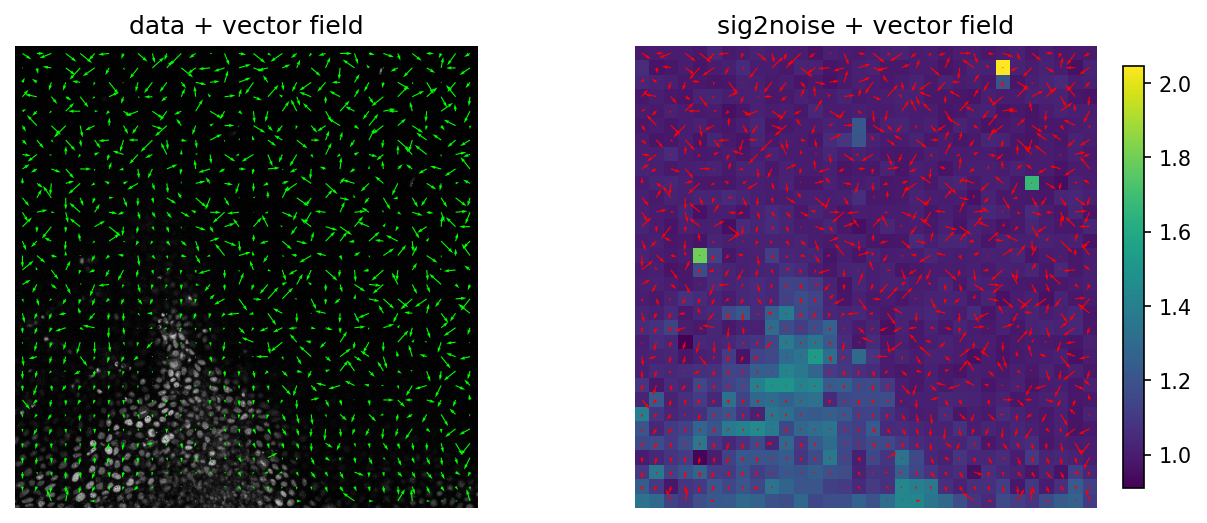

PyObject <matplotlib.quiver.Quiver object at 0x7f3d48f67250>

In [101]:
IA = multi_quickPIV._isize( pivparams );  
ST = multi_quickPIV._step( pivparams ); 

U = VF[ 1, :, : ]; 
V = VF[ 2, :, : ]; 
ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

PyPlot.figure( figsize=(10,4), dpi=150 ); 

subplot( 1, 2, 1 ); title("data + vector field"); axis(false); 
PyPlot.imshow( img1, cmap="gray" )
PyPlot.quiver( xgrid, ygrid, V, -U, color="lime" )

subplot( 1, 2, 2 ); title("sig2noise + vector field"); axis(false); 
PyPlot.imshow( SN ); colorbar( fraction=0.04 ); 
PyPlot.quiver( V, -U, color="red" )

## Trying to segment the data for masked PIV

In [10]:
include("multiscale_multistep_filter.jl")

multiscale_multigrid_gradient_segment (generic function with 1 method)

In [11]:
using ImageAnalysis

hi 
  0.770879 seconds (294 allocations: 69.363 MiB, 13.43% gc time)


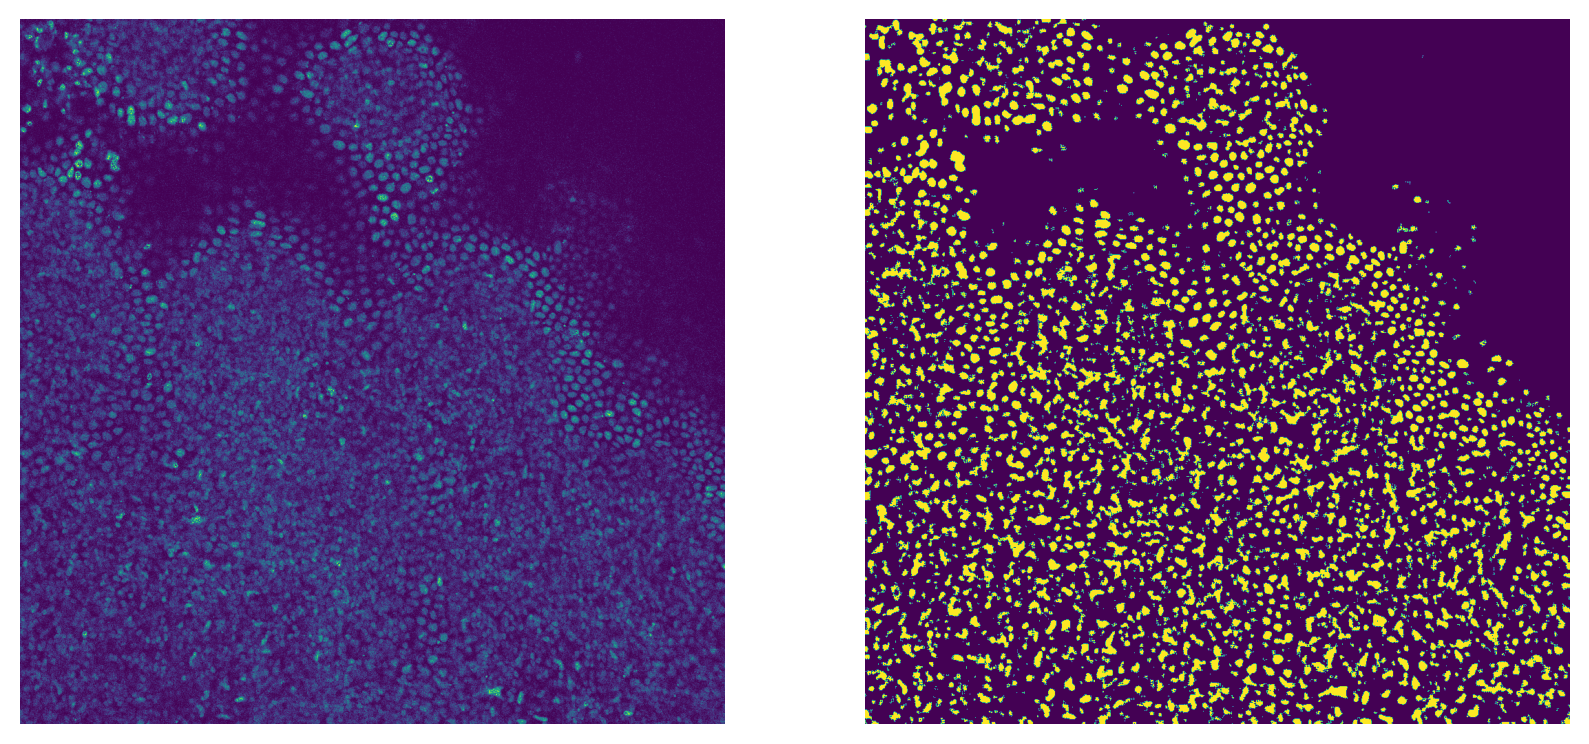

In [56]:
grid_sizes = ( (7,7), )
scales     = ( ((4,4),(2,2)), ) 
steps      = ( ((1,1),(4,4)), ) 

@time out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps ); 

Δ_low = 5000 # expected intensity difference between background and signal
Δ_up = 30000
α = 1.6  # 1.0 - 2.0

mask = out .> ( img1 .+ Δ_low ) .^ α
#mask = (img1 .+ Δ_up) .^α .> out .> ( img1 .+ Δ_low ) .^ α

figure(figsize=(10,5), dpi=200 ); 
subplot( 1, 2, 1 ); axis(false); PyPlot.imshow( img1 ); 
subplot( 1, 2, 2 ); axis(false); PyPlot.imshow( mask ); 

In [57]:
include("multi_quickPIV/src/multi_quickPIV.jl")

#img1 = slices[ :, :, 230 ]; 
#img2 = slices[ :, :, 231 ]; 

pivparams = multi_quickPIV.setPIVParameters( interSize=(32,32), step=(16,16), threshold=0.2, filtFun=(M)->(sum(M)/length(M)) ); 
# consider the IA with percentage of ones obove the threshold.
# --> it woule also useful to not consider the IA with tooo high percentage of ones --> could be noise!
# Is there also a possibe way to set an up threshold?
@time VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 ); 

  6.642353 seconds (2.51 M allocations: 349.650 MiB, 1.46% gc time, 78.03% compilation time)


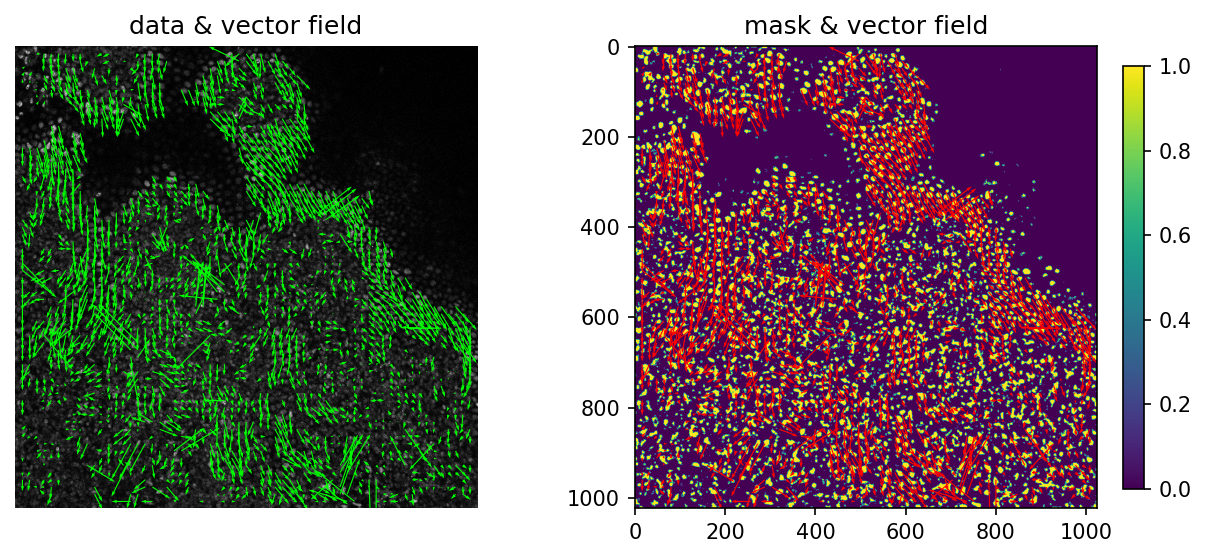

PyObject <matplotlib.quiver.Quiver object at 0x0000015B0E31EB00>

In [63]:
IA = multi_quickPIV._isize( pivparams );  
ST = multi_quickPIV._step( pivparams ); 

U = VF[ 1, :, : ]; 
V = VF[ 2, :, : ]; 
M = sqrt.( U .^ 2 .+ V .^ 2 ); 
U[ M .== 0 ] .= NaN
V[ M .== 0 ] .= NaN
ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

# Postprocessing 
U_, V_ = multi_quickPIV.stdFilter(50, U, V)

PyPlot.figure( figsize=(10,4), dpi=150 ); 

subplot( 1, 2, 1 ); title("data & vector field"); axis(false); 
PyPlot.imshow( img1, cmap="gray" )
PyPlot.quiver( xgrid, ygrid, V_, -U_, color="lime", scale=120)

subplot( 1, 2, 2 ); title("mask & vector field");
PyPlot.imshow( mask ); colorbar( fraction=0.04 ); 
PyPlot.quiver( xgrid, ygrid, V_, -U_, color="red", scale=120)

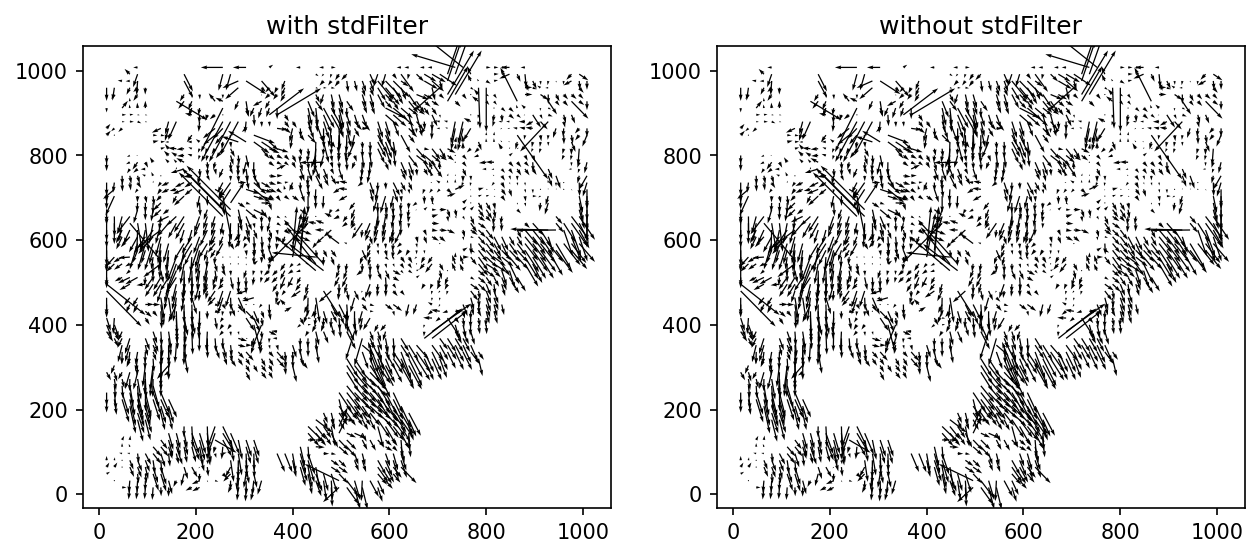

PyObject <matplotlib.quiver.Quiver object at 0x0000015B0EAB3E80>

In [64]:
# Postprocessing 
include("multi_quickPIV/src/postprocessing/postprocessing.jl")
U_, V_ = stdFilter(5, U, V)

PyPlot.figure( figsize=(10,4), dpi=150 ); 
subplot( 1, 2, 1 );title("with stdFilter"); 
PyPlot.quiver( xgrid, ygrid, V_, -U_, scale=120 )

subplot( 1, 2, 2 ); title("without stdFilter");
PyPlot.quiver( xgrid, ygrid, V, -U, scale=120 )

# Postprocessing 
## 1) Mask based on vector length
### But this could also lead to the lost of true long arrows which contains information. 

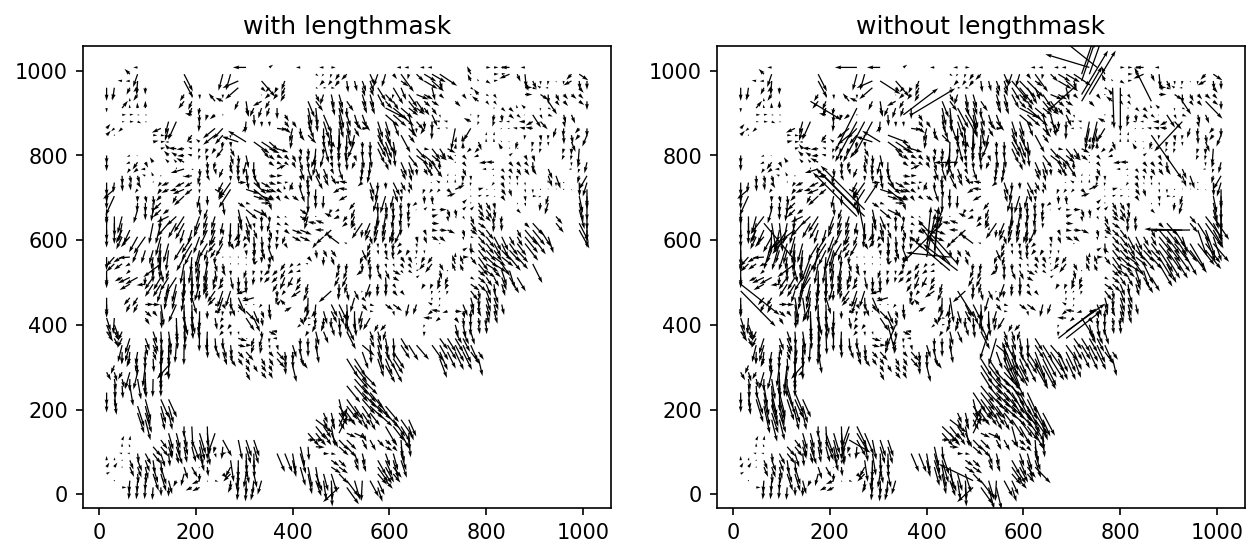

PyObject <matplotlib.quiver.Quiver object at 0x0000015B1030EA40>

In [65]:
M_ = deepcopy(M)
maskM = M_ .< 5
M_ .*= maskM
U_ = deepcopy(U)
V_= deepcopy(V)

U_[ M_ .== 0 ] .= NaN
V_[ M_ .== 0 ] .= NaN

PyPlot.figure( figsize=(10,4), dpi=150 ); 

subplot( 1, 2, 1 );title("with lengthmask"); 
PyPlot.quiver( xgrid, ygrid, V_, -U_, scale=120 )

subplot( 1, 2, 2 ); title("without lengthmask");
PyPlot.quiver( xgrid, ygrid, V, -U, scale=120 )

## 2) Mask based on local mean vectorlength in a grid

In [68]:
rad  = 16               # this defines a 7x7 region around each pixel
N    = (2*rad + 1)^2  # number of pixels in the 7x7 region.
th   =  5.                # removes vectors whose magnitude is th-times higher

mask = zeros( Bool, size( U ) )

63×63 Matrix{Bool}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0

In [70]:
for x in 1+rad:size(U,2)-rad, y in 1+rad:size(U,1)-rad
   avgM = ( sum( M[ x-rad:x+rad, y-rad:y+rad ] ) - M[x,y] ) / ( N - 1 )
   mask[y,x] = (M ./ avgM) .< th
end


LoadError: MethodError: [0mCannot `convert` an object of type [92mBitMatrix[39m[0m to an object of type [91mBool[39m

[0mClosest candidates are:
[0m  convert(::Type{Bool}, [91m::PyCall.PyObject[39m)
[0m[90m   @[39m [32mPyCall[39m [90mC:\Users\Rutian Zhou\.julia\packages\PyCall\1gn3u\src\[39m[90m[4mconversions.jl:55[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:84[24m[39m
[0m  convert(::Type{T}, [91m::Union{Static.StaticBool{N}, Static.StaticFloat64{N}, Static.StaticInt{N}} where N[39m) where T<:Number
[0m[90m   @[39m [33mStatic[39m [90mC:\Users\Rutian Zhou\.julia\packages\Static\6JeQI\src\[39m[90m[4mStatic.jl:420[24m[39m
[0m  ...


## 3) Mask based on global vectorlength  (mean or std)
### This could also probably cancle the true vectors. 

In [125]:
using Statistics
M_g = deepcopy(M)
mean_Mg = Statistics.mean(M_g)
std_Mg = Statistics.std(M_g)

1.9704984f0

In [126]:
maximum( (M_g .- mean_Mg) ) 

12.697274f0

In [122]:
# Mask through n*times global mean length
#m_factor = 4
#mask_Mg = M_g .<= m_factor*mean_Mg 

# Mask through mean + anteil*maximal factor std --> extrem low anteil von std muss genommen werden damit die extrem long arrows are away.
#part = 0.2 # between 0.0 and 1.0
#std_factor = part * maximum( (M_g .- mean_Mg) ) 
# But the theory part here is more meaningfull...

# Mask through mean + n*times std
std_factor = 3

mask_Mg = M_g .<= mean_Mg + std_factor * std_Mg

M_g .*= mask_Mg

63×63 Matrix{Float32}:
 0.0       0.0       1.0        …  0.0       0.0      0.0      0.0
 0.0       0.249348  0.0           0.0       0.0      0.0      0.0
 0.904705  0.0       0.0           0.0       0.0      0.0      0.0
 1.19024   1.23319   0.162712      0.0       0.0      0.0      0.0
 1.0       0.698021  0.0762362     0.0       0.0      0.0      0.0
 0.0       0.0       0.687732   …  0.0       0.0      0.0      0.0
 0.0       0.0       0.830986      0.0       0.0      0.0      0.0
 0.0       0.0       1.05597       0.0       0.0      0.0      0.0
 0.0       0.0       0.0           0.0       0.0      0.0      0.0
 0.0       0.0       0.0           0.0       0.0      0.0      0.0
 0.0       0.0       0.0        …  0.0       0.0      0.0      0.0
 0.0       0.0       0.0           0.0       0.0      0.0      0.0
 0.0       0.0       0.0           0.0       0.0      0.0      0.0
 ⋮                              ⋱            ⋮                 
 0.0       0.0       0.0           0.0    

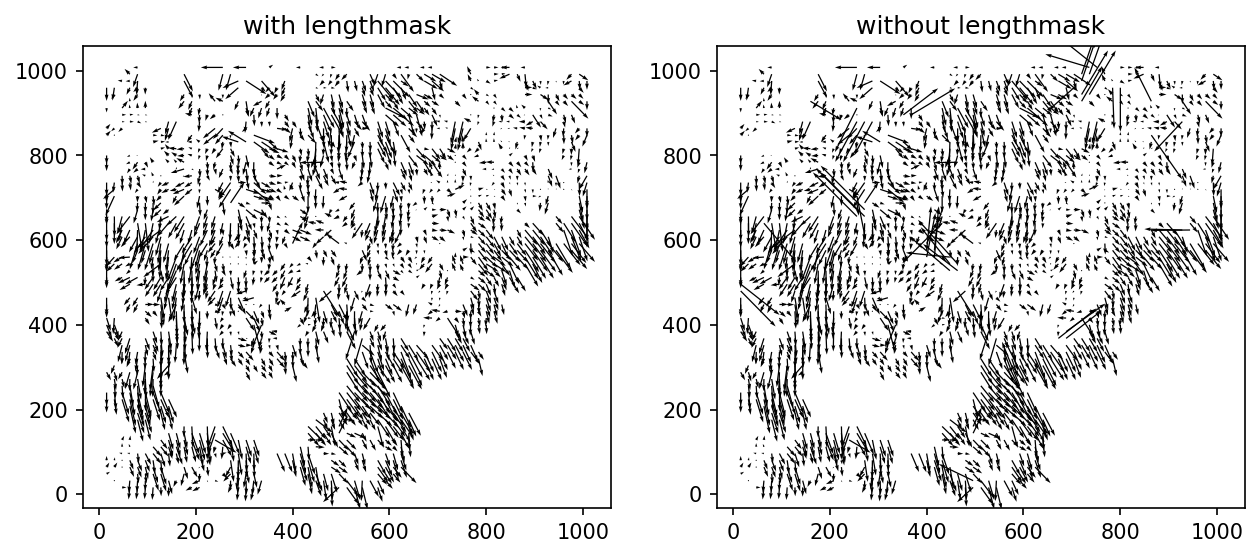

PyObject <matplotlib.quiver.Quiver object at 0x0000015B1986C760>

In [123]:
U_g = deepcopy(U)
V_g = deepcopy(V)
U_g[ M_g .== 0 ] .= NaN
V_g[ M_g .== 0 ] .= NaN

PyPlot.figure( figsize=(10,4), dpi=150 ); 

subplot( 1, 2, 1 );title("with lengthmask"); 
PyPlot.quiver( xgrid, ygrid, V_g, -U_g, scale=120 )

subplot( 1, 2, 2 ); title("without lengthmask");
PyPlot.quiver( xgrid, ygrid, V, -U, scale=120 )

## Mask based on global std